In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from random import choices, sample
from gensim.models import Word2Vec

In [2]:
def negative_sampling(samples, num_of_samples):
    from collections import Counter
    ctr = Counter(samples)
    dict_ctr_freq = {}
    for i in ctr:
        dict_ctr_freq[i] = ctr[i] / len(samples)
    numerator = { pid: freq ** 0.75 for pid, freq in dict_ctr_freq.items()}
    denominator = sum(numerator.values())
    prob = { pid: freq_f/denominator for pid, freq_f in numerator.items()}
    from random import choices
    return choices(list(prob.keys()), weights=list(prob.values()),k=num_of_samples)

In [3]:
def freq_sampling(samples, num_of_samples):
    from collections import Counter
    ctr = Counter(samples)
    dict_ctr_freq = {}
    for i in ctr:
        dict_ctr_freq[i] = ctr[i] / len(samples)
    from random import choices
    return choices(list(dict_ctr_freq.keys()), weights=list(dict_ctr_freq.values()),k=num_of_samples)

---

In [4]:
model_w2v = Word2Vec.load("iid_1days.model")

In [5]:
with open('./iid_pairs/iid_pairs_' '2017-11-25' '.pkl', 'rb') as file:
    iid_pairs = pickle.load(file)

In [6]:
target, _next = zip(*iid_pairs)

In [7]:
len(iid_pairs)

8666470

In [8]:
SAMPLE_SIZE = 8666470

In [9]:
# positive_pairs = freq_sampling(iid_pairs, SAMPLE_SIZE)

In [10]:
positive_pairs = iid_pairs

In [11]:
negative_pairs = list(zip(freq_sampling(target, SAMPLE_SIZE), negative_sampling(_next, SAMPLE_SIZE)))

In [12]:
training_data_sample = [np.hstack(( model_w2v.wv[x[0]], model_w2v.wv[x[1]] )) for x in tqdm(positive_pairs+negative_pairs)]

100%|██████████| 17332940/17332940 [02:10<00:00, 132722.05it/s]


In [13]:
training_data_sample = np.array(training_data_sample)

In [14]:
# # embedding pair
# positive_training_data = np.array([np.hstack(( model_w2v.wv[x[0]], model_w2v.wv[x[1]] )) for x in tqdm(positive_pairs)])
# negative_training_data = np.array([np.hstack(( model_w2v.wv[x[0]], model_w2v.wv[x[1]] )) for x in tqdm(negative_pairs)])

# positive_training_data.shape

# training_data_sample = np.vstack((positive_training_data, negative_training_data))

In [15]:
training_data_sample.shape

(17332940, 256)

In [16]:
ones = np.ones((SAMPLE_SIZE, 1))
zeros = np.zeros((SAMPLE_SIZE, 1))
label = np.vstack((ones, zeros))

In [17]:
label.shape

(17332940, 1)

---

In [18]:
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, losses, metrics, callbacks

Using TensorFlow backend.


In [19]:
X_train, y_train = training_data_sample, label

In [32]:
model = models.Sequential()
model.add(layers.Dense(512, activation='linear', input_shape=(256,)))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(256, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(128, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(64, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.mse])

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

In [35]:
# checkpoint
filepath = './saved_model/' '2017-11-25' '_' + str(SAMPLE_SIZE) + '_' + time.strftime("%m%d", time.localtime()) + ".h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [36]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_split=.4,
                    verbose=1,
                    callbacks=callbacks_list)

Train on 10399764 samples, validate on 6933176 samples
Epoch 1/20
10399764/10399764 [==============================] - 122s 12us/step - loss: 0.4128 - mean_squared_error: 0.1281 - val_loss: 1.4725 - val_mean_squared_error: 0.5529

Epoch 00001: val_loss improved from inf to 1.47252, saving model to ./saved_model/2017-11-25_8666470_0423.h5
Epoch 2/20
10399764/10399764 [==============================] - 122s 12us/step - loss: 0.4053 - mean_squared_error: 0.1259 - val_loss: 1.7358 - val_mean_squared_error: 0.6431

Epoch 00002: val_loss did not improve from 1.47252
Epoch 3/20
10399764/10399764 [==============================] - 122s 12us/step - loss: 0.4013 - mean_squared_error: 0.1249 - val_loss: 1.5873 - val_mean_squared_error: 0.5716

Epoch 00003: val_loss did not improve from 1.47252
Epoch 4/20
10399764/10399764 [==============================] - 122s 12us/step - loss: 0.3993 - mean_squared_error: 0.1243 - val_loss: 1.2736 - val_mean_squared_error: 0.4671

Epoch 00004: val_loss improved

In [37]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

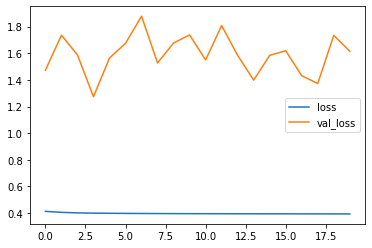

In [38]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [ ]:
pd.DataFrame(history.history)[['mean_squared_error', 'val_mean_squared_error']].plot()